In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')
import xlwings as xw

data1 = pd.read_csv("sample_dataset_v3.csv")

data1.columns
# We have the following columns in the data
# Day of Billing Date, Brand, Article, Site Name, MRP, Promotion Name, Promotion No, Region
# POS Billing Quantity, POS Cost, POS Gross Sales, POS Net Sales WOT, POS RGM, POS Tax Amount,
# POS Total Discount, Distict_Columnns, Vendor, Vendor Code, Fiber, Fabric, Brand Tag, Disclaimer Tag
# C Technique, Broad_Craft, Handloom Mark, Silk Mark, Type, Wash care instruction, Description, Style Code
# Craft Code, Cost Price, Site, bin

Index(['Billing Date', 'Brand', 'Article', 'Site', 'Site Area', 'MRP',
       'Promotion Name', 'Region', 'POS Billing Quantity', 'POS Cost',
       'POS Gross Sales', 'POS Total Discount', 'POS Tax Amount',
       'POS Net Sales WOT', 'POS RGM', 'Vendor', 'Fiber', 'Fabric',
       'Brand Tag', 'Wash Care Instructions', 'C Technique', 'Broad Craft',
       'Handloom Mark', 'Silk Mark', 'Type', 'Style Code', 'Craft Code',
       'Site Name', 'Bin'],
      dtype='object')

In [34]:
data1.head()

,Billing Date,Brand,Article,Site,Site Area,MRP,Promotion Name,Region,POS Billing Quantity,POS Cost,...,Wash Care Instructions,C Technique,Broad Craft,Handloom Mark,Silk Mark,Type,Style Code,Craft Code,Site Name,Bin
0,2023-03-09,Biba,6517116692,ST40,A,7282,P37,R4,1,3486.742249,...,Handwash Separately,C6,B1,no,no,Printed,6517116,C6,ST40A,7000-7999
1,2023-01-10,Ciba,9792126013,ST35,B,6891,P20,R2,1,3366.377476,...,Handwash Separately,C3,B1,no,no,Embroidered,9792126,C3,ST35B,6000-6999
2,2023-01-30,Aiba,2451609893,ST13,A,1373,P16,R1,1,621.996417,...,Handwash Separately,C8,B1,no,no,Tie-Dyed,2451609,C8,ST13A,1000-1999
3,2023-02-08,Ciba,6919239963,ST24,A,4452,P2,R4,1,2182.635892,...,Handwash Separately,C6,B2,no,no,Embroidered,6919239,C6,ST24A,4000-4999
4,2023-01-01,Ciba,1418488906,ST25,B,5220,P13,R1,1,2421.383859,...,Handwash Separately,C4,B2,no,no,Embroidered,1418488,C4,ST25B,5000-5999


In [35]:
data1["POS Billing Quantity"].median()

1.0

In [36]:
data1["Billing Date"]=pd.to_datetime(data1["Billing Date"])

In [49]:
# First this function takes arguments as brand, the date from which you want to do the analysis, 
# the numeric value that will come on x axis eg. POS Gross Sales, the numeric value that will come on y axis
# eg. MD%, a 
# dictionary that maps if you want to aggregate by sum or by mean or by any other function
# and the categorical value names you want to see the grid eg.  'C Technique'
def twobytwo(branda,startdatea,xval,yval,dicta,catvala):
    
    data = data1.copy() # we make a copy so that we do not have to download the data again and again 
    data = data[data['Billing Date']>pd.to_datetime(startdatea)] # We want to take all those dates which are after the start date till end
    data = data[data['Brand']==brand] # we want to filter the data by brand
    
    # Here we create two columns NM% and MD%
    data["NM%"] = data["POS RGM"]/data["POS Net Sales WOT"] # NM% is the net margin % and it is POS RGM / POS Net Sales without tax
    
    data["MD%"] = data["POS Total Discount"]/data["POS Gross Sales"] # MD% is markdown or discount % 
    
    # Now we take the sum of x value(sales) and (probably) mean of y value (discount%) for the catvala( eg. C Technique)
    # that we want  to evaluate
    
    data = data.groupby([catvala]).agg(dicta).reset_index().fillna(0)
    
    
    # The above is a groupby object. We convert it into dataframe
    
    df = pd.DataFrame(data)
    xmed = df[xval].median()
    ymed = df[yval].median()

    
    # Now we define the quadrants based on xal and yval
    df['Quadrant'] = f"Low{xval} Low{yval}"

    df.loc[(df[xval]>xmed) & (df[yval]> ymed),'Quadrant'] = f"High {xval} High {yval}"
    df.loc[(df[xval]>xmed) & (df[yval]<= ymed),'Quadrant'] = f"High {xval} low {yval}"
    df.loc[(df[xval]<=xmed) & (df[yval]> ymed),'Quadrant'] = f"low {xval} High {yval}"
    print("Median Value of x axis:",df[xval].median())
    print("Median value of y axis:",df[yval].median())
    #xw.view(df) if you want to print the df
    # Create separate Bubble charts for each quadrant
    quadrants = df['Quadrant'].unique()
    
    # Dictionary to store x and y limits for each quadrant
    quadrant_limits = {}
    
    for quadrant in quadrants:
        # filter the data for the current quadrant
        quadrant_data = df[df['Quadrant']==quadrant]
        
       
        # Create the bubble chart for the current quadrant
        plt.figure(figsize = (8,6))
        plt.scatter(quadrant_data[xval],quadrant_data[yval],alpha = 0.5, color='red')
        
        # Add Labels for each data point
        for i in range(len(quadrant_data)):
            plt.text(quadrant_data[xval].iloc[i],quadrant_data[yval].iloc[i],quadrant_data[catvala].iloc[i],ha='center')
            
        # Set axis labels and title
        plt.xlabel(xval)
        plt.ylabel(yval)
        plt.title(f'{quadrant} Quadrant Chart')
        
        # Calculate x and y limites for the current quadrant
        x_min, x_max = quadrant_data[xval].min(), quadrant_data[xval].max()
        y_min, y_max = quadrant_data[yval].min(), quadrant_data[yval].max()
        
        # store the x an y limits in the dictionary
        
        quadrant_limits[quadrant] ={'x_min':x_min, 'x_max':x_max, 'y_min':y_min, 'y_max':y_max}
        
        # Draw Lines to separate quadrants
        plt.axhline(y=ymed,color='red',linestyle='dashed',alpha=0.7)
        plt.axvline(x=xmed,color='red',linestyle='dashed',alpha=0.7)
        
        # Show the plot
        plt.grid(False)
        plt.show()
        
    # Calculate the count of items in each quadrant
    quadrant_counts = df['Quadrant'].value_counts()
    
    # Create a bar plot
    plt.figure(figsize = (8,6))
    plt.bar(quadrant_counts.index,quadrant_counts.values)
    
    # Add labels for each bar
    for i, count in enumerate(quadrant_counts.values):
        plt.text(i,count,str(count),ha='center',va='bottom',fontsize=12)
        
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45,ha='right')
    
    # Show the plot
    plt.grid(axis = 'y')
    plt.show()

xmed: 31704.591270235105
ymed: 0.40595260617652584
Median Value of x axis: 31704.591270235105
Median value of y axis: 0.40595260617652584


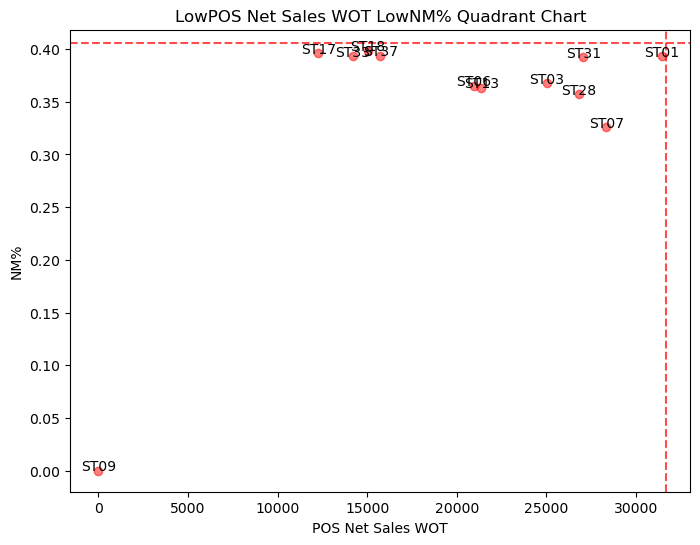

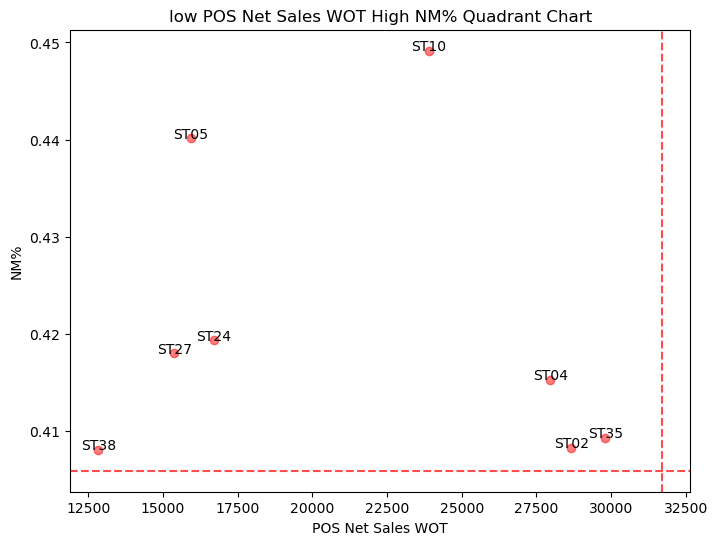

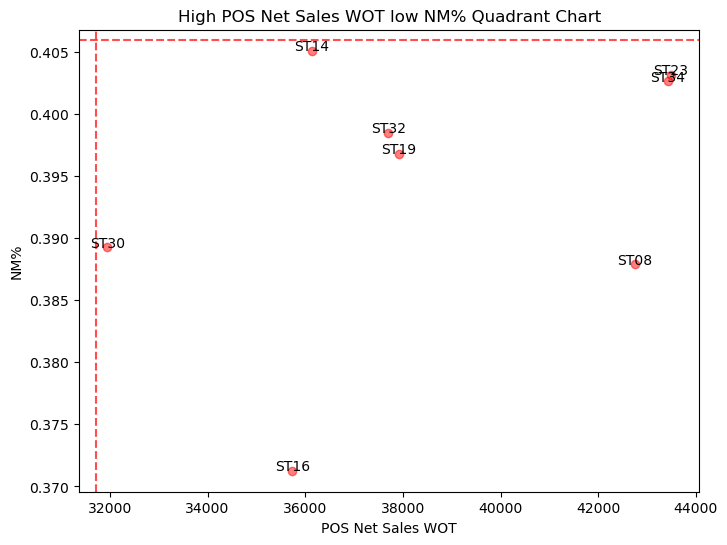

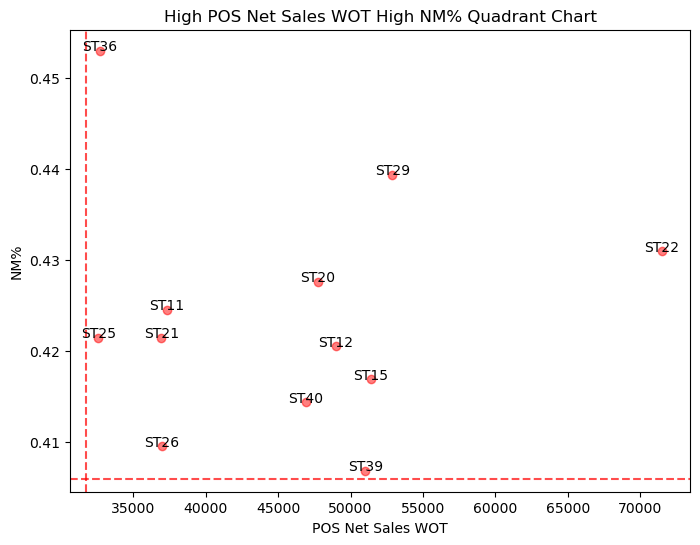

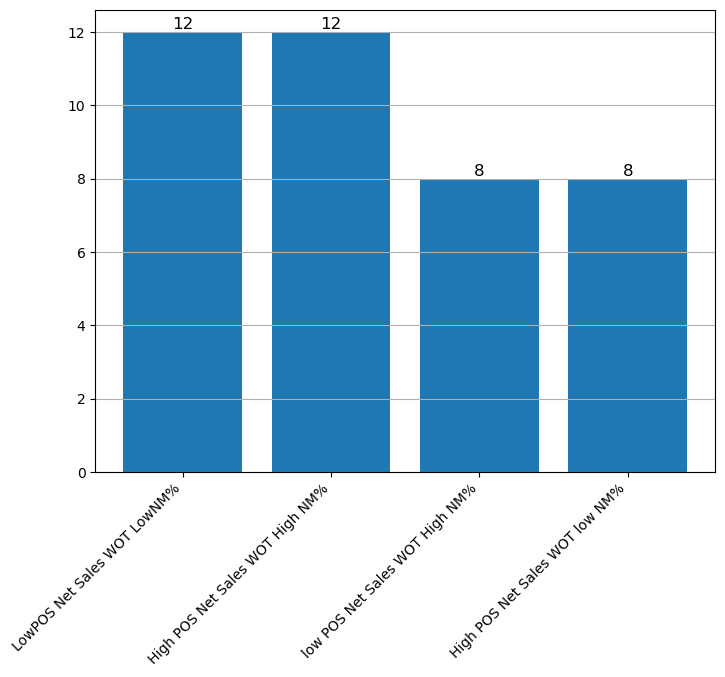

In [51]:
colList = ['Billing Date', 'Brand', 'Article', 'Site', 'Site Area', 'MRP',
       'Promotion Name', 'Region', 'POS Billing Quantity', 'POS Cost',
       'POS Gross Sales', 'POS Total Discount', 'POS Tax Amount',
       'POS Net Sales WOT', 'POS RGM', 'Vendor', 'Fiber', 'Fabric',
       'Brand Tag', 'Wash Care Instructions', 'C Technique', 'Broad Craft',
       'Handloom Mark', 'Silk Mark', 'Type', 'Style Code', 'Craft Code',
       'Site Name', 'Bin']
brand = 'Biba'
startdate = '2023-01-01'
xaxis = 'POS Net Sales WOT'
yaxis = 'NM%'
dict1 = {xaxis:'sum',yaxis:'mean'}
catval = 'Site'
twobytwo(brand,startdate,xaxis,yaxis,dict1,catval)